In [8]:
import subprocess
import json

cluster_name = 'Rhino'
task = 'integration'
version = '18'
container_name = "integration"

# Commands
launch_command = ["mpirun", "-launcher", "manual", "-disable-hostname-propagation", "-verbose", "-hosts", "0,1,2,3", "./mpi-func", "1", "100", "10"]
base_command = ["/usr/local/bin/hydra_pmi_proxy", "--control-port", "192.168.0.1:20000", "--debug", "--rmk", "user", "--launcher", "manual", "--demux", "poll", "--pgid", "0", "--retries", "10", "--usize", "-2", "--proxy-id"]

def run_tasks(overrides):
    cmd = [
        'aws', 'ecs', 'run-task',
        '--cluster', cluster_name,
        '--task-definition', f"{task}:{version}",
        '--launch-type', 'FARGATE',
        '--network-configuration', 'awsvpcConfiguration={subnets=[subnet-01e7cc1bcdb949806],securityGroups=[sg-02fbade4cac831f75],assignPublicIp="ENABLED"}',
        '--count', "1",
        '--overrides', json.dumps(overrides)
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running task: {result.stderr}")
        exit(1)
    output = json.loads(result.stdout)
    return [task['taskArn'] for task in output['tasks']]

def get_task_private_ip(task_arn):
    describe_cmd = [
        'aws', 'ecs', 'describe-tasks',
        '--cluster', cluster_name,
        '--tasks', task_arn
    ]
    result = subprocess.run(describe_cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error describing task: {result.stderr}")
        exit(1)
    output = json.loads(result.stdout)
    task = output['tasks'][0]
    eni_id = task['attachments'][0]['details'][1]['value']
    
    describe_eni_cmd = [
        'aws', 'ec2', 'describe-network-interfaces',
        '--network-interface-ids', eni_id
    ]
    result = subprocess.run(describe_eni_cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error describing network interface: {result.stderr}")
        exit(1)
    output = json.loads(result.stdout)
    private_ip = output['NetworkInterfaces'][0]['PrivateIpAddress']
    return private_ip

def main():
    # Submit launch_command
    launch_overrides = {
        "containerOverrides": [
            {
                "name": container_name,
                "command": launch_command
            }
        ]
    }
    launch_task_arns = run_tasks(launch_overrides)
    print(f"Launch task {launch_task_arns[0]} submitted.")

    # Get private IP address from launch task
    private_ip = get_task_private_ip(launch_task_arns[0])
    print(f"Private IP address: {private_ip}")

    # Update base_command with the new IP address
    base_command[2] = f"{private_ip}:20000"
    # Generate commands with different proxy-id
    commands = [base_command + [str(i)] for i in range(4)]
    # Submit the other commands
    task_arns = []
    for command in commands:
        overrides = {
            "containerOverrides": [
                {
                    "name": container_name,
                    "command": command
                }
            ]
        }
        task_arns.extend(run_tasks(overrides))
    print(f"Tasks {task_arns} submitted.")

main()


KeyboardInterrupt: 

In [ ]:
import subprocess
import json
import time

cluster_name = 'Rhino'
task = 'integration'
version = '18'
task_count = 1
results_file = 'inter4c.txt'


container_name = "integration"
command = ["mpirun", "-np", "4", "./mpi-func", "1", "100", "10"]


def run_tasks(desired_count=1):
    overrides = {
        "containerOverrides": [
            {
                "name": container_name,
                "command": command
            }
        ]
    } 
    cmd = [
        'aws', 'ecs', 'run-task',
        '--cluster', cluster_name,
        '--task-definition', f"{task}:{version}",
        '--launch-type', 'FARGATE',
        '--network-configuration', 'awsvpcConfiguration={subnets=[subnet-01e7cc1bcdb949806],securityGroups=[sg-02fbade4cac831f75],assignPublicIp="ENABLED"}',
        '--count', str(desired_count),
        '--overrides', json.dumps(overrides)
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running task: {result.stderr}")
        exit(1)
    output = json.loads(result.stdout)
    return [task['taskArn'] for task in output['tasks']]

def describe_tasks(task_arns):
    cmd = [
        'aws', 'ecs', 'describe-tasks',
        '--cluster', cluster_name,
        '--tasks'
    ] + task_arns

    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error describing tasks: {result.stderr}")
        exit(1)
    return json.loads(result.stdout)

def wait_for_tasks_to_stop(task_arns):
    """Wait for all tasks to reach the 'STOPPED' state."""
    while True:
        tasks_info = describe_tasks(task_arns)
        all_stopped = all(task['lastStatus'] == 'STOPPED' for task in tasks_info['tasks'])
        if all_stopped:
            break
        time.sleep(10)  # Wait for 10 seconds before checking again

def fetch_and_store_logs(task_arns):
    """Fetch logs for each task and write to a file."""
    with open(results_file, 'w') as f:
        for task_arn in task_arns:
            log_id = task_arn.split('/')[-1]  # Assuming log stream name is the task ARN ID part

            # Fetch logs
            cmd = [
                'aws', 'logs', 'get-log-events',
                '--log-group-name', f"/ecs/{task}",
                '--log-stream-name', f"ecs/{task}/{log_id}"
            ]
            result = subprocess.run(cmd, capture_output=True, text=True)
            if result.returncode != 0:
                print(f"Error getting logs for task {task_arn}: {result.stderr}")
                continue
            log_events = json.loads(result.stdout)['events']
            for event in log_events:
                f.write(event['message'] + '\n')

def main():
    task_arns = run_tasks(desired_count=task_count)
    print(f"Tasks {task_arns} submitted.")
    wait_for_tasks_to_stop(task_arns)
    fetch_and_store_logs(task_arns)
    print("Logs have been written to:", results_file)

main()

In [ ]:
import subprocess
import json
from datetime import datetime
from dateutil.parser import parse as parse_datetime

cluster_name = 'Rhino'
task_arns = [
    'aed4eefbe21640d093865b9b983209ee'
]
cpu = 2
memory = 4

def describe_task(task_arn):
    cmd = [
        'aws', 'ecs', 'describe-tasks',
        '--cluster', cluster_name,
        '--tasks', task_arn
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error describing task: {result.stderr}")
        exit(1)
    output = json.loads(result.stdout)
    return output['tasks'][0]

def calculate_cost(start_time, stop_time):
    runtime = (stop_time - start_time).total_seconds() / 3600
    
    vcpu_price_per_hour = 0.04048
    memory_price_per_hour = 0.004445

    vcpu_hours = cpu * runtime
    memory_hours = memory * runtime

    cost = (vcpu_hours * vcpu_price_per_hour) + (memory_hours * memory_price_per_hour)
    return cost

def main():
    total_cost = 0.0
    for task_arn in task_arns:
        task = describe_task(task_arn)
        start_time = parse_datetime(task['startedAt'])
        stop_time = parse_datetime(task['stoppedAt'])

        print(f"Task {task_arn} started at: {start_time}")
        print(f"Task {task_arn} stopped at: {stop_time}")

        cost = calculate_cost(start_time, stop_time)
        print(f"Estimated cost for task {task_arn}: ${cost:.4f}")
        total_cost += cost

    print(f"Total estimated cost for all tasks: ${total_cost:.4f}")


main()

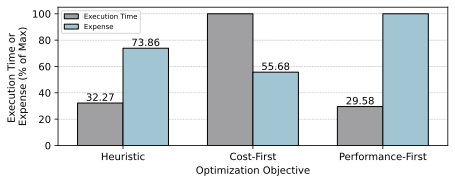

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# Data
data = {
    'Objective': ['Heuristic', 'Cost-First', 'Performance-First'],
    'Execution Time': [35.84, 111.08, 32.86],
    'Expense': [0.0065, 0.0049, 0.0088]
}

palette = ['#A0A0A2', '#9AC9DB'] 

# Create DataFrame
df = pd.DataFrame(data)

# Normalize by the maximum value for each metric to get percentage
df['Execution Time'] = df['Execution Time'] / df['Execution Time'].max() * 100
df['Expense'] = df['Expense'] / df['Expense'].max() * 100

# Create a new DataFrame for plotting
df_melt = df.melt(id_vars='Objective', var_name='Metric', value_name='Percentage')

plt.figure(figsize=(7, 2.5))
bar_plot = sns.barplot(x='Objective', y='Percentage', hue='Metric', data=df_melt, width=0.7, edgecolor='black', linewidth=1.0, palette=palette)

# Add labels and title
bar_plot.set_xlabel('Optimization Objective', fontsize=10)
bar_plot.set_ylabel(f'Execution Time or \nExpense (% of Max)', fontsize=10)
plt.legend(title="", fontsize='7', loc='upper left')
bar_plot.set_axisbelow(True)
bar_plot.yaxis.grid(True, linestyle='--', linewidth=0.5)
bar_plot.tick_params(axis='x', labelsize=10)
bar_plot.tick_params(axis='y', labelsize=10)
# Annotate the bars with the percentage values, except for the maximum values (100)
for p in bar_plot.patches:
    height = p.get_height()
    if height < 100:  # Only annotate bars with height less than 100
        bar_plot.annotate(format(height, '.2f'),
                          (p.get_x() + p.get_width() / 2., height),
                          ha = 'center', va = 'center', 
                          xytext = (0, 5), 
                          textcoords = 'offset points',
                          fontsize=10)

plt.savefig("sched.pdf", format='pdf', bbox_inches='tight')
# Show plot
plt.show()
